# Lab 10: Fully Connected Neural Networks

In this assignment, we will learn fully connected neural network. 


## 1. Example

This assignement should be run on Google Colab where you can use free GPU to accelerate the computation. Please refer to our slides to set up GPU. 

[![Open In Colab][colab badge]][colab]

[colab badge]: https://colab.research.google.com/assets/colab-badge.svg
[colab]: https://colab.research.google.com/github/lduran2/CIS3715_DataScience_2022/blob/lab10/Lab10/Lab10.ipynb

### 1. Install Pytorch

In [ ]:
!pip3 install torch torchvision   # install pytorch

### 2. Check GPU

In [ ]:
!/opt/bin/nvidia-smi  #show GPU 

Sun Apr 10 03:04:26 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### 3. Mount to google drive (optional)

In [ ]:

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### 4. Code

In [ ]:
#Import Libraries
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
args={}
args['batch_size']=100
args['test_batch_size']=100
args['epochs']=10  #The number of Epochs is the number of times you go through the full dataset. 
args['lr']=0.01 #Learning rate is how fast it will decend. 
args['log_interval']=10

In [ ]:
def seed_rnd(a_seed):
    '''
    Seeds all relevant RND libaries.
    '''
    # import and seed numpy if unused
    import numpy
    numpy.random.seed(a_seed)
    # seed Pytorch
    torch.manual_seed(a_seed)
    # seed the GPU(s)
    torch.cuda.manual_seed_all(a_seed)
# end seed_rnd(a_seed)

In [ ]:
# use a constant random seed to make experiment repeatable
seed_rnd(42)

In [ ]:
# build an mlp
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(28*28, 256)   # linear layer (784 -> 256)
        self.fc2 = nn.Linear(256,128)  # linear layer (256 -> 128)
        self.fc3 = nn.Linear(128,10)  # linear layer (128 -> 10)

    def forward(self, x):
        h0 = x.view(-1,28*28) #input layer
        h1 = F.relu(self.fc1(h0)) # hidden layer 1
        h2 = F.relu(self.fc2(h1)) # hidden layer 2
        h3 = self.fc3(h2) # output layer

        return h3

model = Net()
model.cuda() # put the model on GPU
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [ ]:
# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.SGD(model.parameters(),lr = args['lr'])

In [ ]:
#load the data
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args['batch_size'], shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args['test_batch_size'], shuffle=False)

## 2. Tasks

I have changed the `train` and `test` functions
and added some of my own to make it possible to aggregate loss and accuracy.

#### `train` and its callbacks

In [ ]:
def printTrainReport(epoch, i_xamp, N_XAMPS, pc_accuracy, r_loss):
    print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, i_xamp, N_XAMPS, pc_accuracy, r_loss))
# end def printTrainReport(epoch, i_xamp, N_XAMPS, pc_accuracy, r_loss)

In [ ]:
def createAppendLossTo(queue):
    def appendLossToQueue(epoch, i_xamp, N_XAMPS, pc_accuracy, r_loss):
        queue.append(r_loss)
    # end def appendLossToQueue(epoch, i_xamp, N_XAMPS, pc_accuracy, r_loss)
    return appendLossToQueue
# end def createAppendLossTo(queue)(epoch, i_xamp, N_XAMPS, pc_accuracy, r_loss)

In [ ]:
def train(epoch, callbacks=[printTrainReport]):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.cuda(), target.cuda()
        
        output = model(data)
        loss = criterion(output, target)

        # compute gradients
        optimizer.zero_grad()
        loss.backward()

        #to do a one-step update on our parameter.
        optimizer.step()

        #Apply callbacks to the loss periodically. 
        if batch_idx % args['log_interval'] == 0:
            for callback in callbacks:
                callback(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item())

#### `test` and its callbacks

In [ ]:
def printTestReport(epoch, r_test_loss, N_CORRECTS, N_XAMPS, pc_accuracy):
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
        .format(r_test_loss, N_CORRECTS, N_XAMPS, pc_accuracy))
# end def printTestReport(epoch, r_test_loss, N_CORRECTS, N_XAMPS, pc_accuracy)

In [ ]:
def createAppendAccuracyTo(queue):
    def appendAccuracyToQueue(
          epoch, r_test_loss, N_CORRECTS, N_XAMPS, pc_accuracy):
        queue.append(pc_accuracy)
    # end def appendAccuracyToQueue(
    #     epoch, r_test_loss, N_CORRECTS, N_XAMPS, pc_accuracy)
    return appendAccuracyToQueue
# end def createAppendAccuracyTo(queue)(
#     epoch, r_test_loss, N_CORRECTS, N_XAMPS, pc_accuracy)

In [ ]:
def test(epoch=-1, callbacks=[printTestReport]):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = data.cuda(), target.cuda()

        output = model(data)
        test_loss += criterion(output, target).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] 
        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()

    test_loss /= len(test_loader.dataset)

    for callback in callbacks:
        callback(
            epoch, test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset))

### 1. Please use other activation functions, e.g., sigmoid, tanh, and then plot the training loss and testing accuracy. 

When plotting the training loss, the x-axis is iteration and the y-axis is training loss. When plotting the testing accuracy,  the x-axis is epoch and the y-axis is the training loss.

#### activation functions

In [ ]:
#a test value for testing activation functions
test_s = torch.Tensor([[-1, 0, 1], [-2, 0, 2], [1, 0, 1]])
print(test_s)

tensor([[-1.,  0.,  1.],
        [-2.,  0.,  2.],
        [ 1.,  0.,  1.]])


In [ ]:
def sigmoid(s):
    return 1/(1 + torch.exp(-s))
# end def sigmoid(s)

print(sigmoid(test_s))

tensor([[0.2689, 0.5000, 0.7311],
        [0.1192, 0.5000, 0.8808],
        [0.7311, 0.5000, 0.7311]])


In [ ]:
def tanh(s):
    '''
    Hyperbolic tangent.
    '''
    return (2*sigmoid(2*s) - 1)
# end def tanh(s)

print(tanh(test_s))

tensor([[-0.7616,  0.0000,  0.7616],
        [-0.9640,  0.0000,  0.9640],
        [ 0.7616,  0.0000,  0.7616]])


In [ ]:
def create_leaky_relu(alpha=1e-2):
    '''
    ReLU that leaks on negative input.
    @param alpha : float = negative slope
    '''
    def leaky_relu(s):
        return torch.max(alpha*s, s)
    # end def leaky_relu(s)
    return leaky_relu
# end def create_leaky_relu(alpha=1e-2)(s)

# get a default leaky ReLU
leaky_relu = create_leaky_relu()

print(leaky_relu(test_s))

tensor([[-0.0100,  0.0000,  1.0000],
        [-0.0200,  0.0000,  2.0000],
        [ 1.0000,  0.0000,  1.0000]])


In [ ]:
# the original Re(ctified) L(inear) U(nit)
# relu = -0. if s = 0
relu = create_leaky_relu(alpha=-0.)

print(relu(test_s))

tensor([[0., -0., 1.],
        [0., -0., 2.],
        [1., -0., 1.]])


In [ ]:
def create_elu(alpha=1.):
    '''
    E(xponential)=L(inear) U(nit).
    @param alpha : float = negative coefficient
    '''
    def elu(s):
        return (s + (-s + alpha*(torch.exp(s) - 1))*(s <= 0))
    # end def elu(s)
    return elu
# end def create_elu(alpha=1.)(s)

# get a default ELU
elu = create_elu()

print(elu(test_s))

tensor([[-0.6321,  0.0000,  1.0000],
        [-0.8647,  0.0000,  2.0000],
        [ 1.0000,  0.0000,  1.0000]])


In [ ]:
def testTensorOrientation():
    #show the Pandas data frame
    import pandas as pd
    print('===Pandas data frame===')
    print(pd.DataFrame({'a': [1, 2], 'b': [3, 4]})**2)
    # show the Pytorch tensor
    print('===Pytorch tensor===')
    print(torch.Tensor([[1, 2], [3, 4]])**2)
# end def testTensors()

testTensorOrientation()

===Pandas data frame===
   a   b
0  1   9
1  4  16
===Pytorch tensor===
tensor([[ 1.,  4.],
        [ 9., 16.]])


In the previous cell,
we see that `pandas` data frames are oriented by column
whereas Pytorch tensors are oriented by row instead.

In [ ]:
def softmax(s):
    '''
    For each column, each cell is
        exp(s)/sum(exp(s)).
    '''
    # sum along axis=1, which is by rows
    norm = torch.sum(torch.exp(s), 1)
    # we reshape to a column vector of norms
    norm_cols = norm.reshape(-1,1)
    return torch.exp(s)/norm_cols
# end def softmax(s)

print(softmax(test_s))

tensor([[0.0900, 0.2447, 0.6652],
        [0.0159, 0.1173, 0.8668],
        [0.4223, 0.1554, 0.4223]])


Create the activation models.

In [ ]:
# create a list of models
models = [model]
# model names
model_names = ['Net']

In [ ]:
# activation functions
activates = (sigmoid, tanh, relu, leaky_relu, elu, softmax)
model_names += ('Sigmoid', 'tanh', 'ReLU', 'Leaky ReLU', 'ELU', 'softmax')

In [ ]:
# build an mlp that uses a specific activation function
class Activation(nn.Module):
    def __init__(self, activate):
        super(Activation, self).__init__()
        
        self.fc1 = nn.Linear(28*28, 256)   # linear layer (784 -> 256)
        self.fc2 = nn.Linear(256,128)  # linear layer (256 -> 128)
        self.fc3 = nn.Linear(128,10)  # linear layer (128 -> 10)

        self.activate = activate

    def forward(self, x):
        h0 = x.view(-1,28*28) #input layer
        h1 = self.activate(self.fc1(h0)) # hidden layer 1
        h2 = self.activate(self.fc2(h1)) # hidden layer 2
        h3 = self.activate(self.fc3(h2)) # output layer

        return h3
# end class Activation(nn.Module)

In [ ]:
#create the activation function models
for activate in activates:
    models.append(Activation(activate))
    models[-1].cuda() # put the last model on GPU

#print the first activation model
# they all look identical as strings
print(models[1])

Train and test each model.

In [ ]:
#dictionaries for model to losses, accuracies.
loss_dict = {}
accuracy_dict = {}

for model, name in zip(models, model_names):
    #name the model
    print('======{}======'.format(name))

    #Create callback for appending losses.
    loss_dict[name] = []
    appendLoss = createAppendLossTo(loss_dict[name])
    #Create callback for appending accuracies.
    accuracy_dict[name] = []
    appendAccuracy = createAppendAccuracyTo(accuracy_dict[name])

    #loop through epoches.
    for epoch in range(1, args['epochs'] + 1):
        train(epoch, callbacks=(printTrainReport, appendLoss))
        test(epoch, callbacks=(printTestReport, appendAccuracy))

    print()

#create data frames from maps
losses = pd.DataFrame(loss_dict)
accuracies = pd.DataFrame(accuracy_dict)

======Net======
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.306634
Train Epoch: 1 [1000/60000 (2%)]	Loss: 2.283218
Train Epoch: 1 [2000/60000 (3%)]	Loss: 2.243291
Train Epoch: 1 [3000/60000 (5%)]	Loss: 2.219450
Train Epoch: 1 [4000/60000 (7%)]	Loss: 2.197454
Train Epoch: 1 [5000/60000 (8%)]	Loss: 2.162927
Train Epoch: 1 [6000/60000 (10%)]	Loss: 2.101262
Train Epoch: 1 [7000/60000 (12%)]	Loss: 2.088319
Train Epoch: 1 [8000/60000 (13%)]	Loss: 2.044811
Train Epoch: 1 [9000/60000 (15%)]	Loss: 1.943084
Train Epoch: 1 [10000/60000 (17%)]	Loss: 1.878040
Train Epoch: 1 [11000/60000 (18%)]	Loss: 1.835300
Train Epoch: 1 [12000/60000 (20%)]	Loss: 1.738544
Train Epoch: 1 [13000/60000 (22%)]	Loss: 1.663665
Train Epoch: 1 [14000/60000 (23%)]	Loss: 1.524293
Train Epoch: 1 [15000/60000 (25%)]	Loss: 1.604650
Train Epoch: 1 [16000/60000 (27%)]	Loss: 1.409848
Train Epoch: 1 [17000/60000 (28%)]	Loss: 1.304045
Train Epoch: 1 [18000/60000 (30%)]	Loss: 1.246237
Train Epoch: 1 [19000/60000 (32%)]	Loss: 1.137148
Tra

In [ ]:
losses

,Net,Sigmoid,tanh,ReLU,Leaky ReLU,ELU,softmax
0,2.306634,2.311714,2.299449,2.300189,2.307920,2.322921,2.302845
1,2.283218,2.302858,2.306322,2.311559,2.306707,2.315713,2.302926
2,2.243291,2.311781,2.314031,2.311091,2.295137,2.335889,2.302497
3,2.219450,2.305431,2.325886,2.311403,2.309775,2.292083,2.303159
4,2.197454,2.311798,2.338658,2.299278,2.300221,2.313163,2.303544
...,...,...,...,...,...,...,...
595,0.165749,2.294499,2.315161,2.299729,2.306120,2.307704,2.302339
596,0.134152,2.305026,2.312526,2.307458,2.305922,2.326939,2.302710
597,0.087051,2.306191,2.313963,2.320302,2.311450,2.319136,2.302558
598,0.228055,2.304497,2.321942,2.302535,2.306501,2.308650,2.303172


In [ ]:
accuracies

,Net,Sigmoid,tanh,ReLU,Leaky ReLU,ELU,softmax
0,tensor(88.7500),tensor(9.8000),tensor(11.6700),tensor(11.0900),tensor(10.2400),tensor(8.6400),tensor(8.9200)
1,tensor(90.9700),tensor(9.8000),tensor(11.6700),tensor(11.0900),tensor(10.2400),tensor(8.6400),tensor(8.9200)
2,tensor(92.4200),tensor(9.8000),tensor(11.6700),tensor(11.0900),tensor(10.2400),tensor(8.6400),tensor(8.9200)
3,tensor(92.9100),tensor(9.8000),tensor(11.6700),tensor(11.0900),tensor(10.2400),tensor(8.6400),tensor(8.9200)
4,tensor(93.6200),tensor(9.8000),tensor(11.6700),tensor(11.0900),tensor(10.2400),tensor(8.6400),tensor(8.9200)
5,tensor(94.1100),tensor(9.8000),tensor(11.6700),tensor(11.0900),tensor(10.2400),tensor(8.6400),tensor(8.9200)
6,tensor(94.4300),tensor(9.8000),tensor(11.6700),tensor(11.0900),tensor(10.2400),tensor(8.6400),tensor(8.9200)
7,tensor(94.8400),tensor(9.8000),tensor(11.6700),tensor(11.0900),tensor(10.2400),tensor(8.6400),tensor(8.9200)
8,tensor(95.1500),tensor(9.8000),tensor(11.6700),tensor(11.0900),tensor(10.2400),tensor(8.6400),tensor(8.9200)
9,tensor(95.4800),tensor(9.8000),tensor(11.6700),tensor(11.0900),tensor(10.2400),tensor(8.6400),tensor(8.9200)


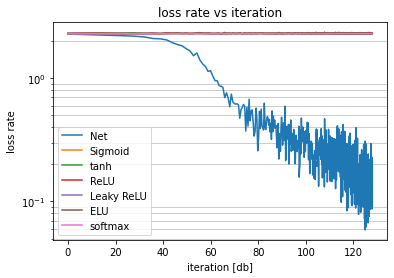

In [ ]:
# we will plot semilogy with dB on x, like a BER plot
N_ITERATIONS = losses.shape[0]
iterations_lin = torch.Tensor(range(N_ITERATIONS))
iterations_db = 20*torch.log(iterations_lin)
# plot the loss
fig, ax = plt.subplots(1, 1)
ax.semilogy(iterations_db, losses)
ax.set_title('loss rate vs iteration')
ax.set_xlabel('iteration [db]')
ax.set_ylabel('loss rate')
ax.legend(model_names)
ax.grid(color='silver', which='minor', axis='y', linestyle='solid')
fig.show()

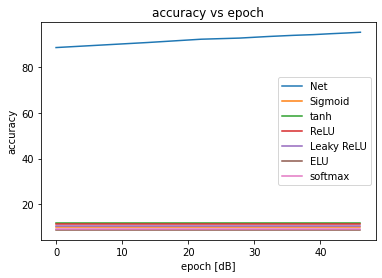

In [ ]:
# we will plot with dB on x.
# this linearizes for the Net model
epoch_lin = torch.Tensor(range(1, (len(accuracies) + 1)))
epoch_db = 20*torch.log(epoch_lin)
# plot the accuracy
fig, ax = plt.subplots(1, 1)
ax.plot(epoch_db, accuracies['Net'])
ax.set_title('accuracy vs epoch')
ax.set_xlabel('epoch [dB]')
ax.set_ylabel('accuracy')
ax.legend(model_names)
fig.show()

### 2. Please use different layers in the model, e.g., 1 layer, 5 layers, 10 layers,  and then plot the training loss and testing accuracy.

In [ ]:
# your code